# Assignment 3_1: TDNN and RNN Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from models import *
from learning import *
from utility import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [5]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000].to(device), y_data[:5000].to(device) # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:].to(device), y_data[5000:].to(device)

train_x, val_x = dev_x[:4000].to(device), dev_x[4000:].to(device)
train_y, val_y = dev_y[:4000].to(device), dev_y[4000:].to(device)

In [4]:
len(train_x), len(val_x), len(test_x)

(4000, 1000, 5000)

## TDNN

In [7]:
hyperparams = {
    'batch_size': [64], 
    'lr':  [0.001, 0.003, 0.005],
    'weight_decay': [0, 1e-6],
    'epochs': [20],
    'window_size': [10, 20, 30],
    'hidden_size': [20, 30, 50],
}

grid_tdnn = GridSearch(hyperparams)

model_selection_history = grid_tdnn.tdnn_grid_search(train_x, train_y, val_x, val_y, verbose=False)
df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('grid_tdnn_search.csv')

In [8]:
df_results = pd.read_csv('grid_tdnn_search.csv', index_col=0)
df_results.sort_values(by='val_mse', ascending=True).head(10)

,batch_size,lr,weight_decay,epochs,window_size,hidden_size,train_mse,val_mse
config_21,64,0.003,0.000000,20,20,20,0.000204,0.000385
config_51,64,0.005,0.000001,20,30,20,0.000191,0.000462
config_40,64,0.005,0.000000,20,20,30,0.000108,0.000468
config_4,64,0.001,0.000000,20,20,30,0.000270,0.000505
config_5,64,0.001,0.000000,20,20,50,0.000193,0.000513
config_24,64,0.003,0.000000,20,30,20,0.000216,0.000519
config_12,64,0.001,0.000001,20,20,20,0.000225,0.000539
config_16,64,0.001,0.000001,20,30,30,0.000212,0.000540
config_41,64,0.005,0.000000,20,20,50,0.000101,0.000572
config_23,64,0.003,0.000000,20,20,50,0.000170,0.000580


In [32]:
window_size = 20
batch_size = 64
lr = 0.003
weight_decay = 0
epochs = 20
hidden_size = 20

tdnn = TDNN(window_size=window_size, hidden_size=hidden_size, output_size=1).to(device)

train_dataset = TDNNDataset(train_x, train_y, window_size=window_size)
val_dataset = TDNNDataset(val_x, val_y, window_size=window_size)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

t_h, val_h = train_tdnn(tdnn, train_loader=train_loader, val_loader=val_loader, lr=lr, weight_decay=weight_decay, epochs=epochs, verbose=True)

Epoch 0 - Train MSE: 0.007423715433105826 - Val MSE: 0.0038226668257266283
Epoch 1 - Train MSE: 0.0020650053407908196 - Val MSE: 0.0013187676668167114
Epoch 2 - Train MSE: 0.0009931949205652234 - Val MSE: 0.0011422991519793868
Epoch 3 - Train MSE: 0.0006893186221113576 - Val MSE: 0.0008069190662354231
Epoch 4 - Train MSE: 0.00046905166227444417 - Val MSE: 0.0007454190053977072
Epoch 5 - Train MSE: 0.0004094061259243135 - Val MSE: 0.0007303716847673059
Epoch 6 - Train MSE: 0.0003885627425800536 - Val MSE: 0.0007141915848478675
Epoch 7 - Train MSE: 0.0003739008557565126 - Val MSE: 0.0007014915463514626
Epoch 8 - Train MSE: 0.0003573877943886651 - Val MSE: 0.0006883507594466209
Epoch 9 - Train MSE: 0.0003403484990398976 - Val MSE: 0.0006730433087795973
Epoch 10 - Train MSE: 0.00032089602355549613 - Val MSE: 0.0006497512804344296
Epoch 11 - Train MSE: 0.0002967829112469825 - Val MSE: 0.0006242622039280832
Epoch 12 - Train MSE: 0.0002700009123174592 - Val MSE: 0.0005957447574473917
Epoch 13

### WARNING: From the plot may seems overfitting but looking at the values(above), both training mse and validation mse decrease at each epoch

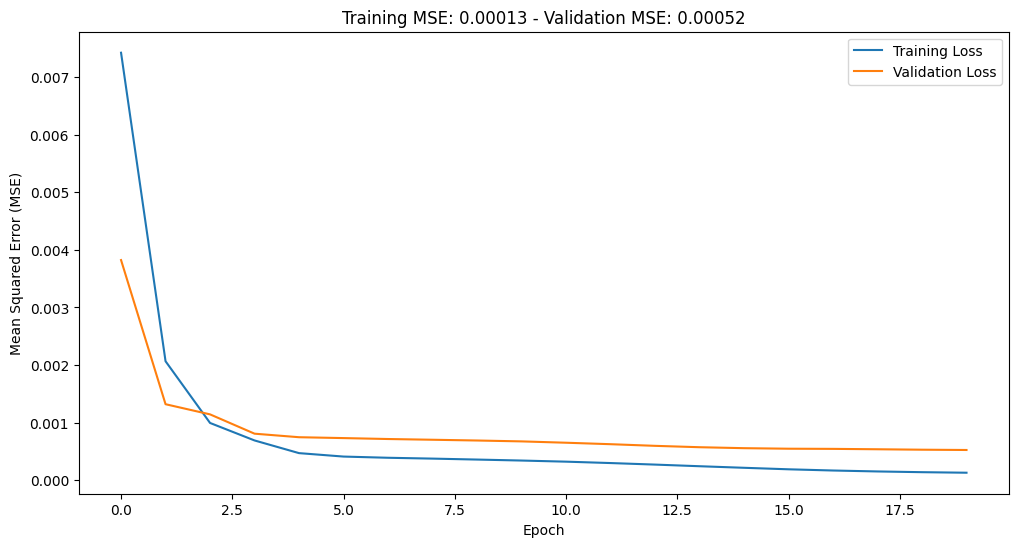

In [43]:
plot_loss(t_h, val_h)

### Retrain TDNN

In [ ]:
window_size = 20
batch_size = 64
lr = 0.003
weight_decay = 0
epochs = 20
hidden_size = 20

final_tdnn = TDNN(window_size=window_size, hidden_size=hidden_size, output_size=1).to(device)

retrain_dataset = TDNNDataset(dev_x, dev_y, window_size=window_size)
retrain_loader = data.DataLoader(retrain_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TDNNDataset(test_x, test_y, window_size=window_size)
test_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

retrain_h, test_h = train_tdnn(final_tdnn, train_loader, val_loader, lr=lr, weight_decay=weight_decay, epochs=epochs, verbose=False)

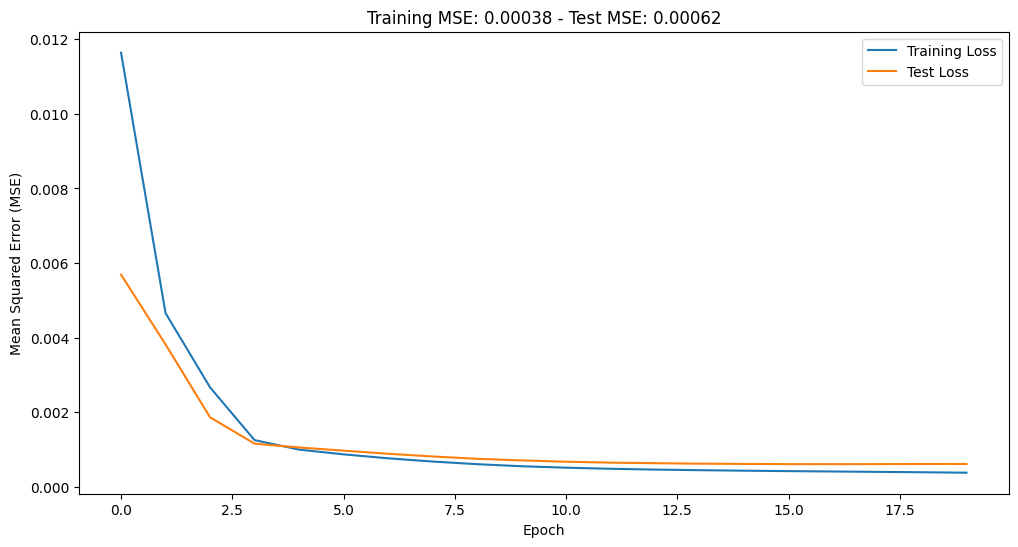

In [44]:
plot_loss(retrain_h, test_h, test=True)

### Training(+Validation) set Reconstruction

In [2]:
window_size = 20
batch_size = 64
lr = 0.003
weight_decay = 0
epochs = 20
hidden_size = 20

final_tdnn = TDNN(window_size=window_size, hidden_size=hidden_size, output_size=1).to(device)
final_tdnn.load_state_dict(torch.load('tdnn_narma10.pt'))

<All keys matched successfully>

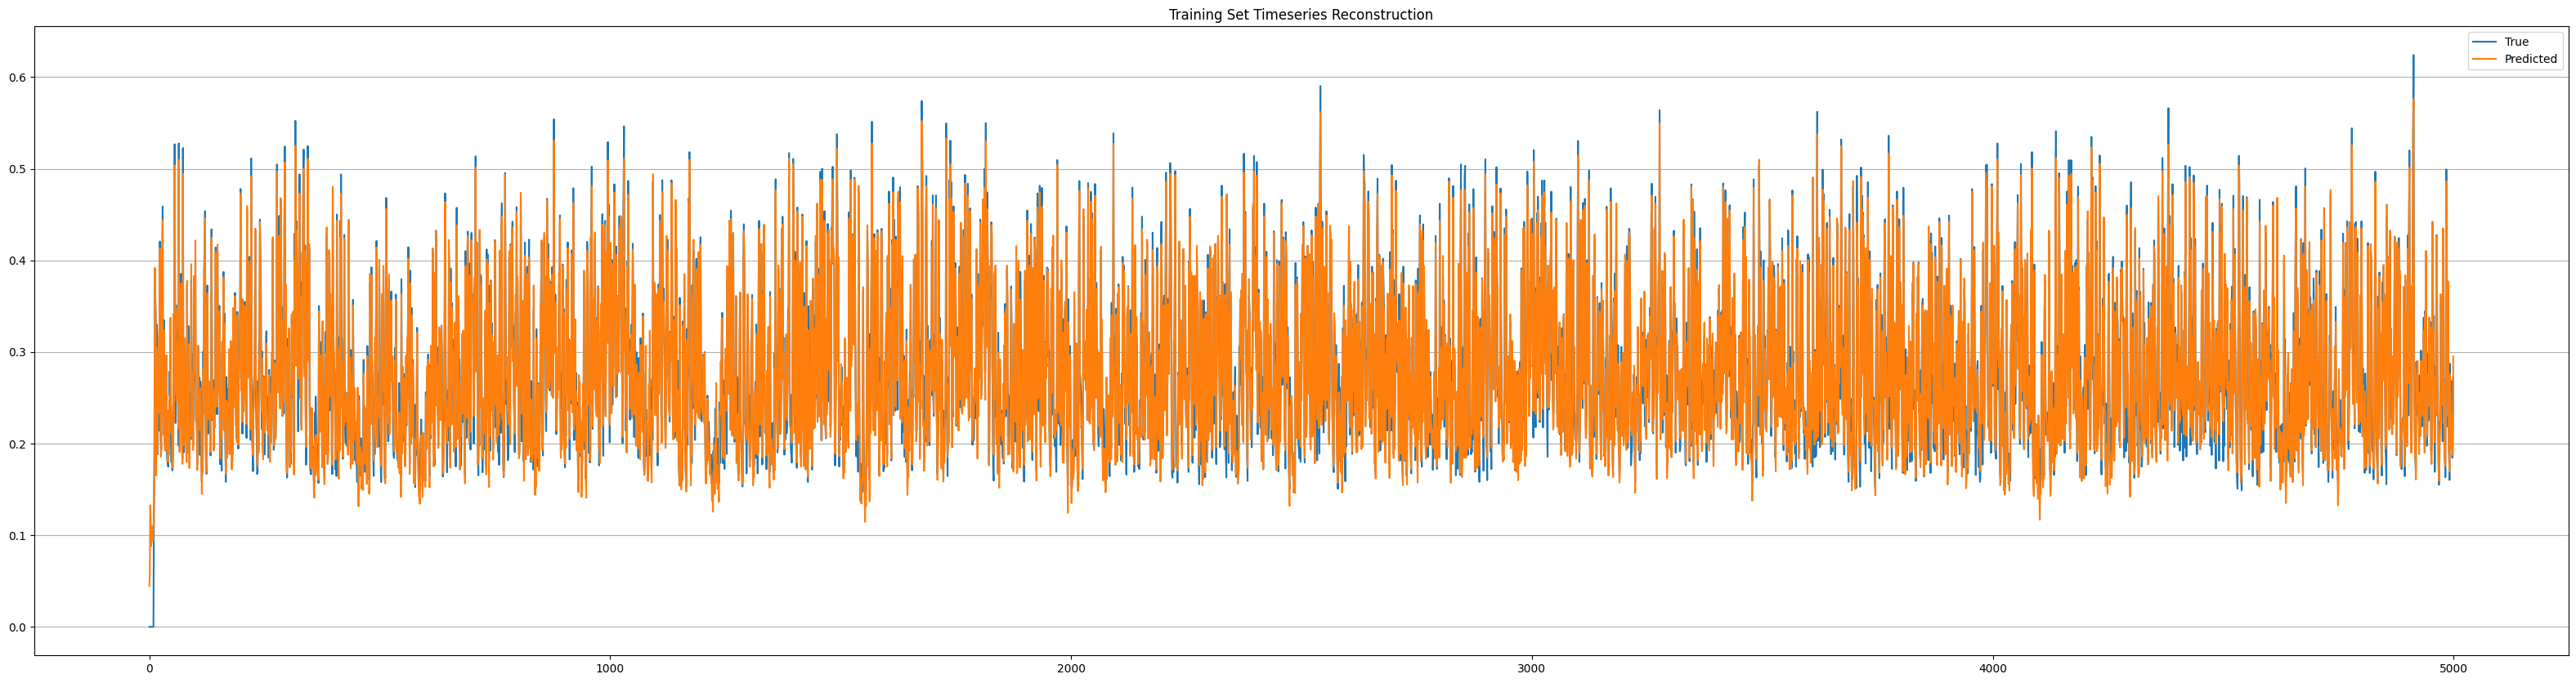

In [6]:
plt.figure(figsize=(40, 10))
plt.grid(True, axis='y')
plt.title('Training Set Timeseries Reconstruction') 

retrain_dataset = TDNNDataset(dev_x, dev_y, window_size=window_size)
retrain_loader = data.DataLoader(retrain_dataset, batch_size=batch_size, shuffle=False)

retrain_loader = data.DataLoader(retrain_dataset, batch_size=len(retrain_dataset), shuffle=False)
for x, y in retrain_loader:
    with torch.no_grad():
        out = final_tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()

### Test Set Reconstruction

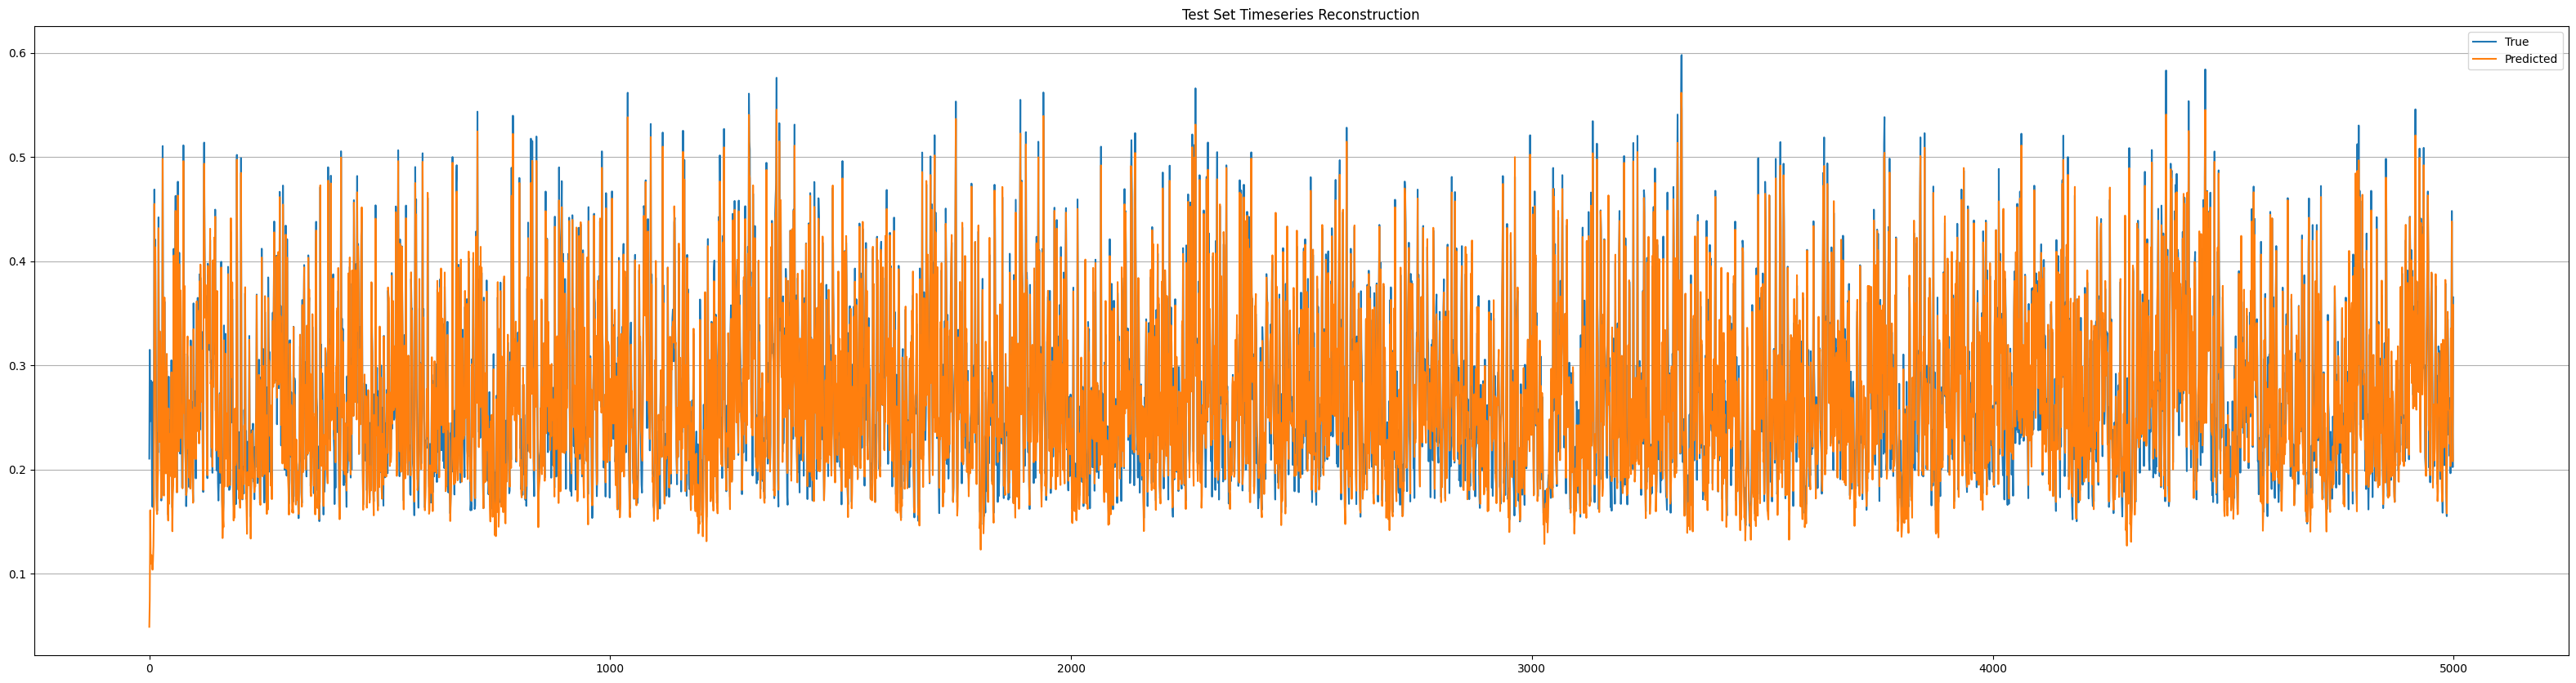

In [8]:
plt.figure(figsize=(40, 10))
plt.grid(True, axis='y')
plt.title('Test Set Timeseries Reconstruction')

test_dataset = TDNNDataset(test_x, test_y, window_size=window_size)
test_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

for x, y in test_loader:
    with torch.no_grad():
        out = final_tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()

In [38]:
# I comment this to avoid overwriting the model accidentally
''' torch.save(final_tdnn.state_dict(), 'tdnn_narma10.pt') '''

## RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from models import *
from learning import *
from utility import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000].to(device), y_data[:5000].to(device) # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:].to(device), y_data[5000:].to(device)

train_x, val_x = dev_x[:4000].to(device), dev_x[4000:].to(device)
train_y, val_y = dev_y[:4000].to(device), dev_y[4000:].to(device)

In [4]:
len(train_x), len(val_x), len(test_x)

(4000, 1000, 5000)

In [32]:
hyperparams = {
    'batch_size': [64, 128], 
    'lr':  [0.001, 0.005, 0.0001, 0.0005],
    'weight_decay': [0, 1e-6],
    'epochs': [100],
    'clip_threshold': [0], # no clipping
    'hidden_size': [100, 200, 300]
}

grid_rnn = GridSearch(hyperparams)

model_selection_history = grid_rnn.rnn_grid_search(train_x, train_y, val_x, val_y, verbose=False)
df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('grid_rnn_search.csv')

In [5]:
df_results = pd.read_csv('grid_rnn_search.csv', index_col=0)
df_results.sort_values(by='val_mse', ascending=True).head(10)

,batch_size,lr,weight_decay,epochs,clip_threshold,hidden_size,train_mse,val_mse
config_33,128,0.005,0.000001,100,0,100,0.000342,0.000104
config_9,64,0.005,0.000001,100,0,100,0.000380,0.000142
config_34,128,0.005,0.000001,100,0,200,0.000342,0.000225
config_10,64,0.005,0.000001,100,0,200,0.000505,0.000318
config_31,128,0.005,0.000000,100,0,200,0.000646,0.000413
config_32,128,0.005,0.000000,100,0,300,0.000308,0.000433
config_1,64,0.001,0.000000,100,0,200,0.000595,0.000441
config_2,64,0.001,0.000000,100,0,300,0.000624,0.000460
config_4,64,0.001,0.000001,100,0,200,0.000632,0.000473
config_8,64,0.005,0.000000,100,0,300,0.000682,0.000517


In [31]:
batch_size = 128
lr = 0.005
weight_decay = 1e-6
clip_threshold = 0
epochs = 100
hidden_size = 100

rnn = VanillaRNN(input_size=1, hidden_size=hidden_size, output_size=1).to(device)

train_dataset = RNNDataset(train_x, train_y)
val_dataset = RNNDataset(val_x, val_y)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

t_h, val_h = train_rnn(rnn, train_loader=train_loader, val_loader=val_loader, lr=lr, weight_decay=weight_decay, epochs=epochs, clip_threshold=clip_threshold, verbose=False)

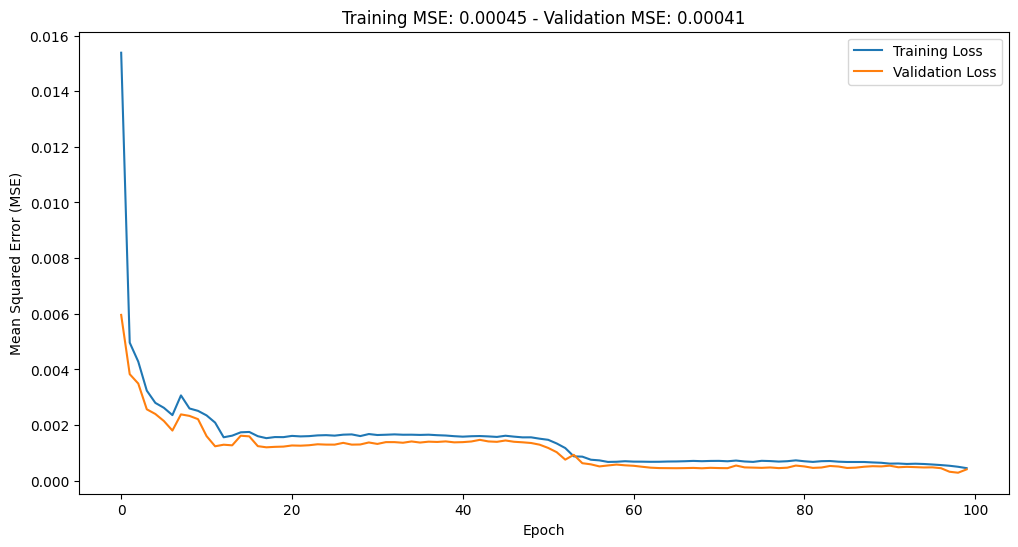

In [32]:
plot_loss(t_h, val_h)

### Retrain RNN

In [33]:
batch_size = 128
lr = 0.005
weight_decay = 1e-6
clip_threshold = 0
epochs = 100
hidden_size = 100

final_rnn = VanillaRNN(input_size=1, hidden_size=hidden_size, output_size=1).to(device)

retrain_dataset = RNNDataset(dev_x, dev_y)
retrain_loader = data.DataLoader(retrain_dataset, batch_size=batch_size, shuffle=False)

test_dataset = RNNDataset(test_x, test_y)
test_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

retrain_h, test_h = train_rnn(final_rnn, train_loader=retrain_loader, val_loader=test_loader, lr=lr, weight_decay=weight_decay, epochs=epochs, clip_threshold=clip_threshold, verbose=False)

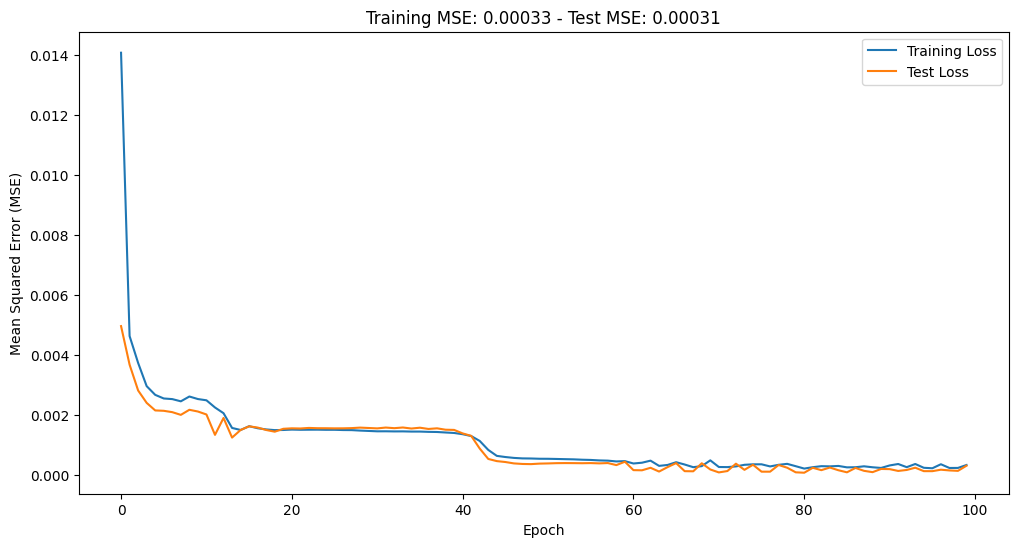

In [34]:
plot_loss(retrain_h, test_h, test=True)

In [36]:
# Comment this to avoid overwriting the model accidentally
''' torch.save(final_rnn.state_dict(), 'rnn_narma10.pt') '''

### Training (+ validation) set Reconstruction

In [37]:
batch_size = 128
lr = 0.005
weight_decay = 1e-6
clip_threshold = 0
epochs = 100
hidden_size = 100

final_rnn = VanillaRNN(input_size=1, hidden_size=hidden_size, output_size=1).to(device)
final_rnn.load_state_dict(torch.load('rnn_narma10.pt'))

<All keys matched successfully>

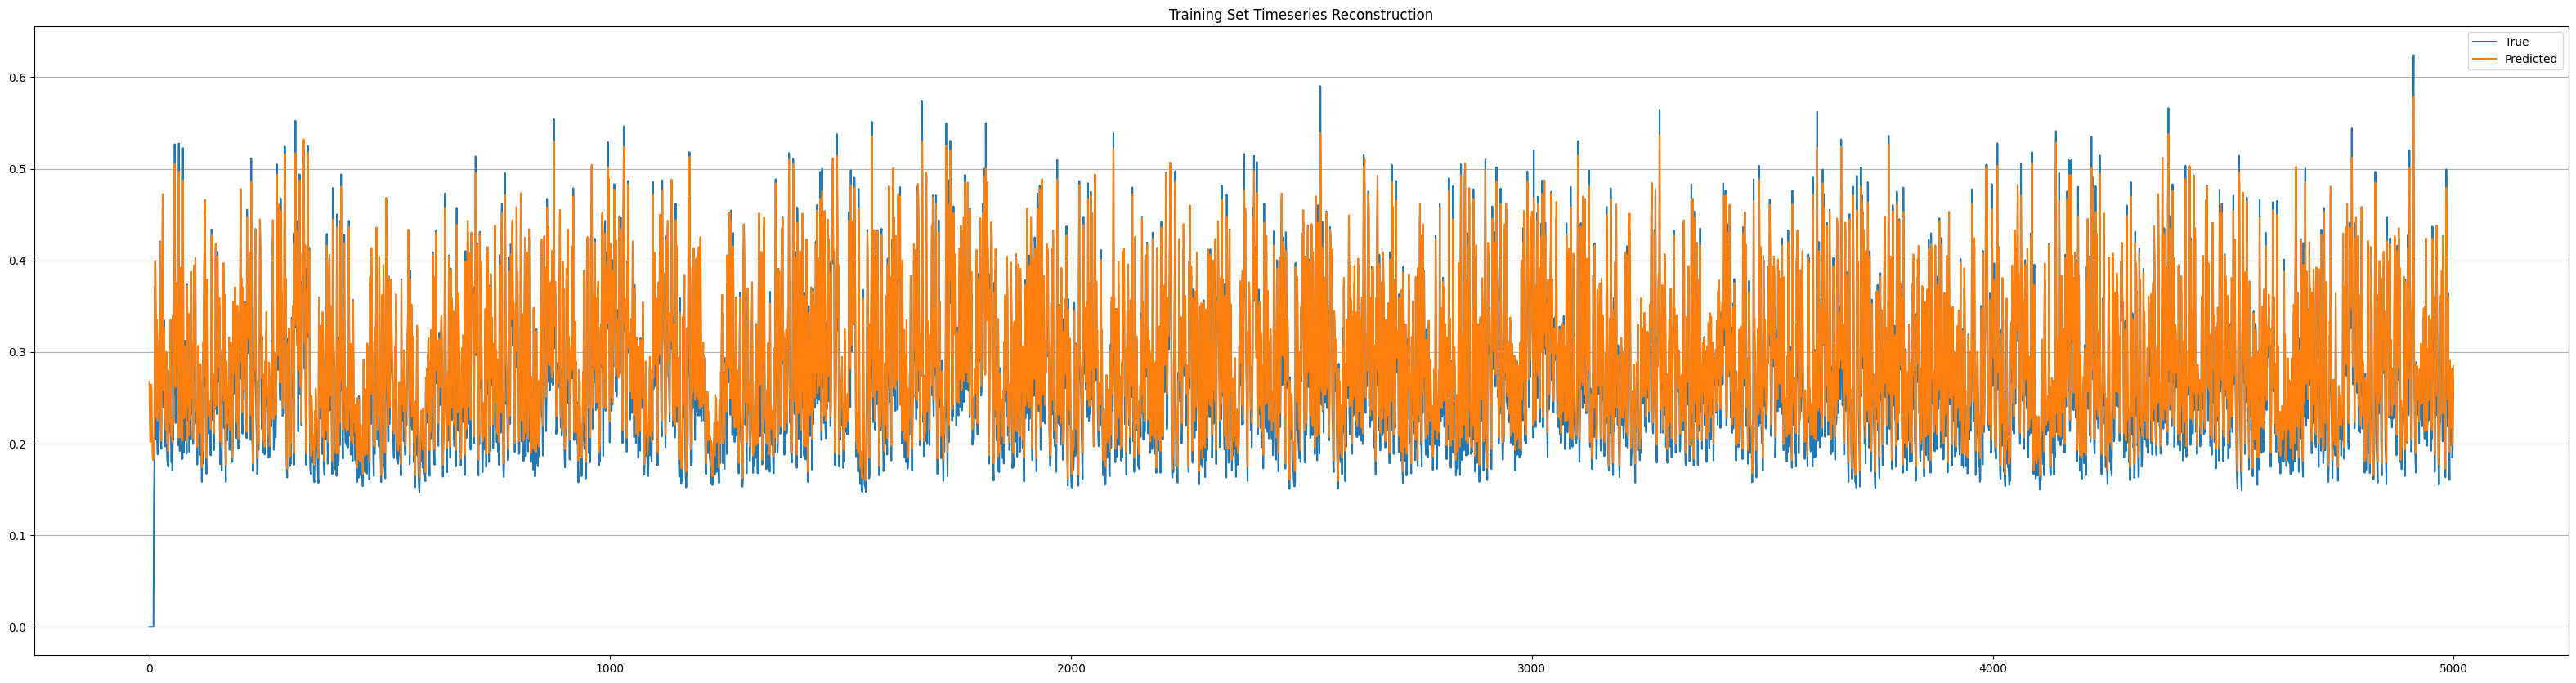

In [39]:
h_last = None
dev_loader = data.DataLoader(retrain_dataset, batch_size=len(retrain_dataset), shuffle=False)

plt.figure(figsize=(40, 10))
plt.grid(True, axis='y')
plt.title('Training Set Timeseries Reconstruction')

for x, y in dev_loader:
    with torch.no_grad():
        x = x.unsqueeze(1)
        out, h_last = final_rnn(x, h_last)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()

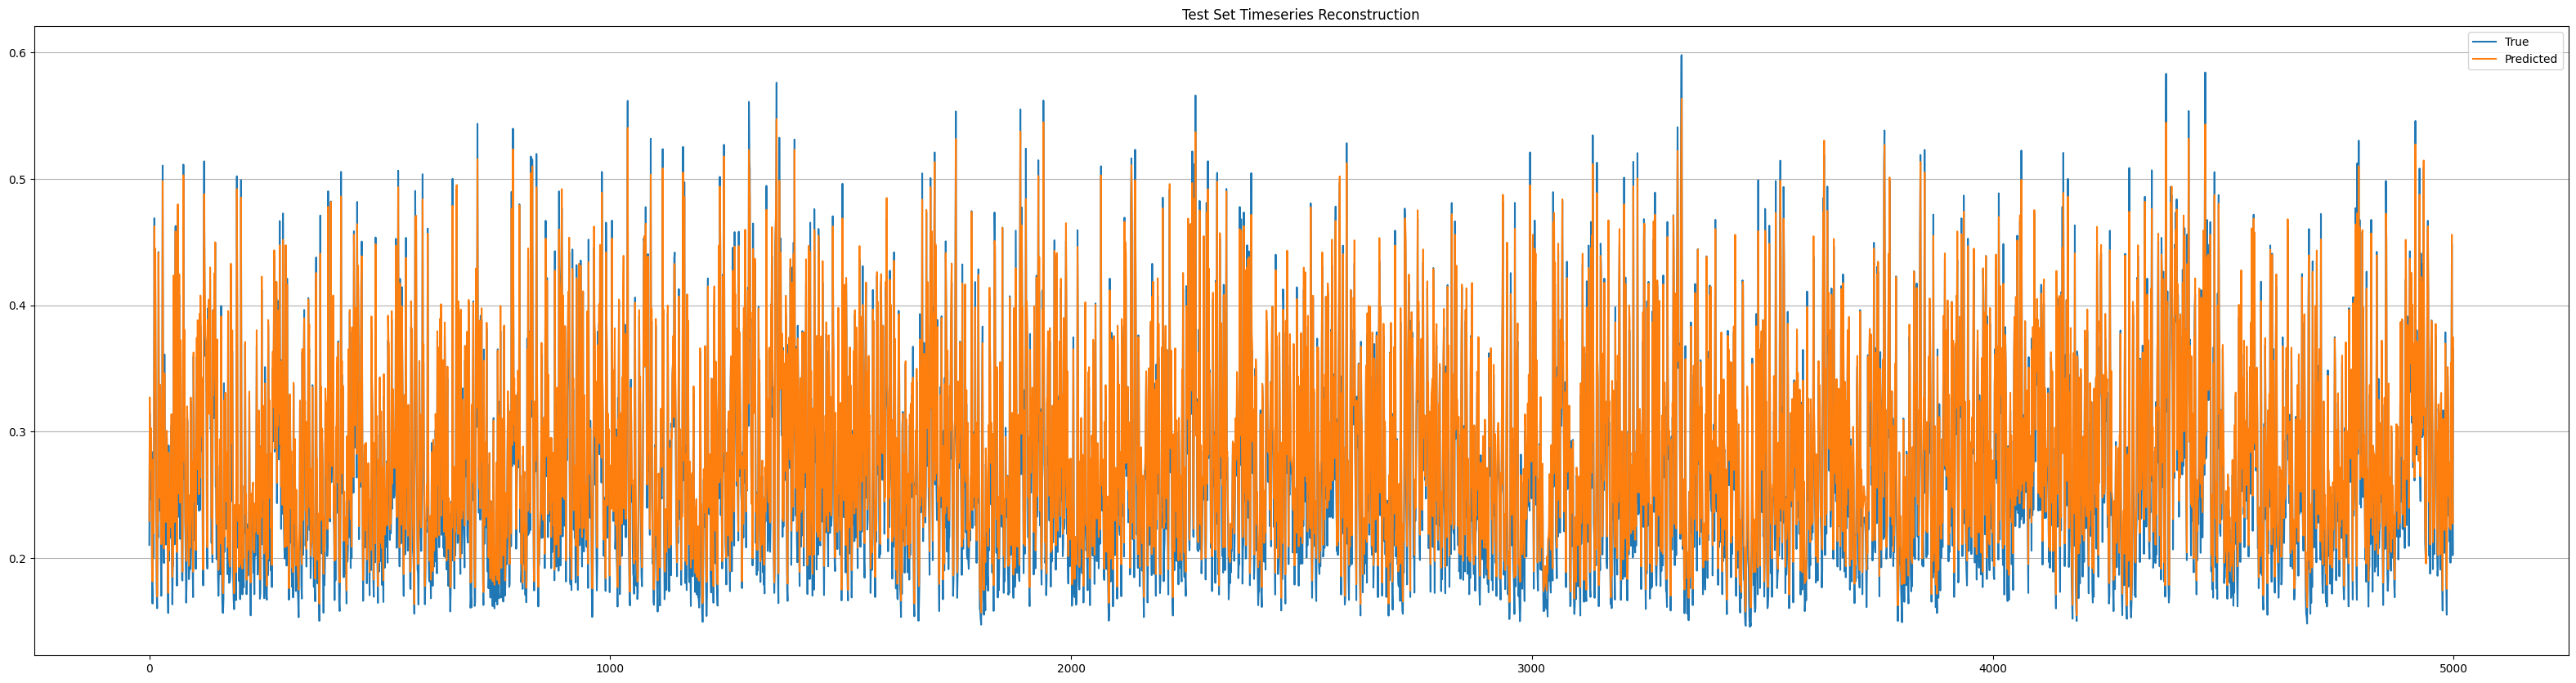

In [41]:
test_dataset = RNNDataset(test_x, test_y)
test_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

plt.figure(figsize=(40, 10))
plt.grid(True, axis='y')
plt.title('Test Set Timeseries Reconstruction')

for x, y in test_loader:
    with torch.no_grad():
        x = x.unsqueeze(1)
        out, h_last = final_rnn(x, h_last) # first 'h_last' is NOT None (because it is the last from the training reconstruction)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()